In [6]:
using Revise

In [7]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using RigidBodySim
using Flux
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models
using DataFrames
using Blink
using DataFrames

In [8]:
robot = BoxAtlas(add_contacts=true)
position_bounds(findjoint(mechanism(robot), "floating_base")) .= RigidBodyDynamics.Bounds(-Inf, Inf)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 3828`, ProcessRunning), TCPSocket(RawFD(74) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(2, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(79) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 2, Nullable{Any}(true))))

In [9]:
interval_net, lqrsol = jldopen("boxatlas-regularized.jld2") do file
    file["net"], file["lqrsol"]
end
interval_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, interval_net), Δt=0.05)

upperbound_net = jldopen("boxatlas-regularized-upperbound.jld2") do file
    file["net"]
end
upperbound_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, upperbound_net), Δt=0.05)

lowerbound_net = jldopen("boxatlas-regularized-lowerbound.jld2") do file
    file["net"]
end
lowerbound_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, lowerbound_net), Δt=0.05)

policy_net = jldopen("boxatlas-regularized-mimic.jld2") do file
    file["net"]
end

policy_net_controller = let net = policy_net
    function (τ, t, x)
        τ .= Flux.Tracker.data(net(LearningMPC.qv(x)))
    end
end

lqr_mpc = LearningMPC.mpc_controller(robot, lqrsol, Δt=0.05);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [37]:
lqrsol.S

22×22 Array{Float64,2}:
   802.677         -8.72229e-6   …   2.97897      -2.97897    
    -0.000106227  113.566            2.55917       2.55917    
 -1287.07           1.31574e-5      -4.80968       4.80968    
    -0.0980062     -0.000447325     -0.000817948   0.000803322
     0.098002      -0.00044751       0.000803321  -0.000817931
  -308.192          2.5204e-6    …  -1.17679       1.17679    
   308.192         -2.5204e-6        1.17679      -1.17679    
    -0.0312623      0.000508005     -0.000589261   0.000538118
     0.0312745      0.00052738       0.00053865   -0.000588828
   141.577        113.566            3.08823       2.0301     
  -141.577        113.566        …   2.0301        3.08823    
    16.9431        -2.13197e-7       1.96926      -1.96926    
    -2.65633e-6     2.55917          2.3976        2.3976     
   -27.0816         3.25102e-7      -2.84747       2.84747    
     0.00853584     3.29753e-5      -0.000146      0.000155339
    -0.00853594     3.29714e-5 

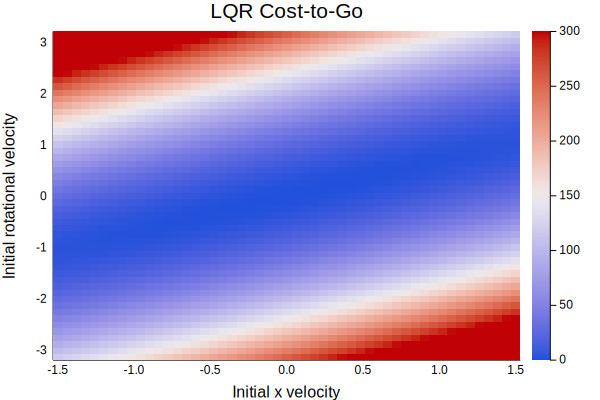

In [45]:
xx = linspace(-1.5, 1.5, 51)
yy = linspace(-π, π, 51)
getstate = (x, y) -> begin
    z = copy(lqrsol.x0)
    z[11 + 1] = x
    z[11 + 3] = y
    z
end
plt = heatmap(xx, yy, (x, y) -> (getstate(x, y) - lqrsol.x0)' * lqrsol.S * (getstate(x, y) - lqrsol.x0), 
    color=:coolwarm, clim=(0, 300))
title!(plt, "LQR Cost-to-Go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Initial rotational velocity")
savefig(plt, "lqr_cost_to_go.pdf")
plt

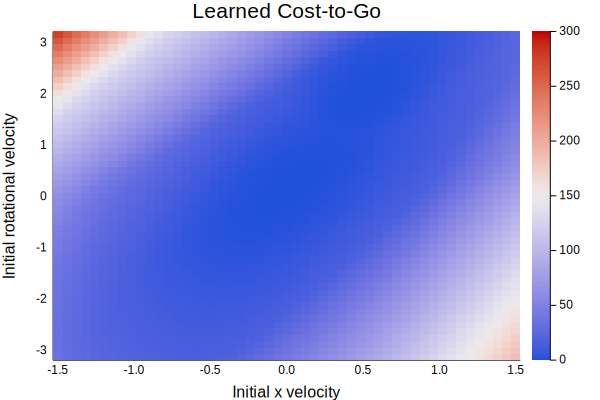

In [46]:
plt = heatmap(xx, yy, (x, y) -> Flux.Tracker.data(interval_net(getstate(x, y)))[], color=:coolwarm, clim=(0, 300))
title!(plt, "Learned Cost-to-Go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Initial rotational velocity")
savefig(plt, "learned_cost_to_go.pdf")
plt

In [10]:
policies = [(lqrsol, "LQR"), 
            (lqr_mpc, "MPC + LQR cost"),
            (policy_net_controller, "Policy Net"), 
            (interval_net_mpc, "MPC + Learned Interval"),
            (upperbound_net_mpc, "MPC + Learned Upper Bound"),
            (lowerbound_net_mpc, "MPC + Learned Lower Bound")
]

tables = map(policies) do args
    controller, label = args
    LearningMPC.run_evaluations(
        controller,
        label,
        robot,
        lqrsol,
        [(1, [0])],
        [(1, linspace(-1.5, 1.5, 15)), (3, linspace(-π, π, 15))]; 
        mvis=mvis,
        horizon=400)
end
cost_table = vcat(tables...)

Progress:   0%|                                         |  ETA: 0:08:55WARNING: Instability detected. Aborting
Progress:  84%|██████████████████████████████████       |  ETA: 0:01:22WARNING: Instability detected. Aborting
Progress: 100%|█████████████████████████████████████████| Time: 0:08:26
Progress: 100%|█████████████████████████████████████████| Time: 1:13:47
Progress: 100%|█████████████████████████████████████████| Time: 0:07:47
Progress:  75%|███████████████████████████████          |  ETA: 0:16:52WARNING: Instability detected. Aborting
Progress:  97%|████████████████████████████████████████ |  ETA: 0:01:47WARNING: Instability detected. Aborting
Progress: 100%|█████████████████████████████████████████| Time: 1:06:32
Progress:  25%|██████████                               |  ETA: 0:51:45WARNING: Instability detected. Aborting
Progress:  87%|████████████████████████████████████     |  ETA: 0:08:51WARNING: Instability detected. Aborting
Progress: 100%|███████████████████████████████

,controller,q0,v0,Δt,horizon,qf,vf,running_cost,terminal_cost
1,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.5, 0.0, -3.14159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[1.055, 0.121229, -2.3148, -1.88632e-5, -6.97994e-5, -0.0501036, 0.785512, 0.800091, 0.595724, 0.474787, 0.950201]","[-0.00520393, 0.00654249, 0.0205124, 0.000275233, 0.000252417, 1.02301e-6, 9.55872e-6, 7.64559e-5, 0.0126667, -8.56698e-6, -1.53174e-5]",9981.27,20352.9
2,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.28571, 0.0, -3.14159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-0.417641, 0.476694, -0.235192, 0.386444, 0.51664, 0.728864, 0.785329, 0.428078, 0.412199, 0.807671, 0.511259]","[-1.3988, -0.0874182, -4.89008, -4.43083, 5.06692, -5.93283, 10.124, 1.36714, -1.92014, -2.25169, 1.79984]",876.222,1571.03
3,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.07143, 0.0, -3.14159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-0.624001, 0.755318, -0.214877, 1.16533e-5, 0.586996, 0.0129506, 0.78541, 0.665448, 0.664425, 0.800083, 0.870201]","[0.00590886, 0.00761631, 0.000776002, -0.00193502, -0.0772838, -0.0340056, -1.15745e-5, -0.00605816, 0.0265584, 0.269737, -0.0195506]",568.225,19.0767
4,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.857143, 0.0, -3.14159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-0.614862, 0.756718, -0.201343, 3.34249e-5, 0.571472, -0.0137291, 0.785416, 0.670968, 0.67205, 0.793367, 0.881745]","[0.0109754, 0.00866782, 0.00890927, 0.0281799, -0.0824733, -0.0127901, -0.000424956, -0.0111518, 0.0285369, 0.178734, -0.0261949]",593.242,19.1167
5,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.642857, 0.0, -3.14159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-0.521192, 0.725596, -0.179424, 0.00528073, 0.507447, 0.199108, 0.785412, 0.638958, 0.653268, 0.802088, 0.859464]","[0.000106743, -0.0243401, -0.0231386, -0.0425514, -0.0122157, 0.0789476, -0.00124105, -0.0107345, 0.012013, -0.2995, 0.283103]",589.307,12.4662
6,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.428571, 0.0, -3.14159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-0.526508, 0.724632, -0.19727, 0.000175311, 0.580154, 0.203221, 0.78541, 0.638763, 0.620683, 0.810192, 0.845759]","[0.0112617, -0.00642299, 0.0300564, 0.0215259, -0.106644, 0.0806408, -0.0010911, -0.0186091, 0.0441389, -0.0892686, -0.0578403]",739.747,13.3372
7,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.214286, 0.0, -3.14159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[1.01474, 0.0302656, -2.40273, -4.54675e-5, -9.65937e-5, -0.0501033, 0.785512, 0.8001, 0.681178, 0.474786, 0.950199]","[-0.00301119, 0.00316024, 0.0103095, 8.54629e-5, 7.91939e-5, 1.40252e-7, 2.49311e-6, 1.09826e-5, 0.00621907, -8.65528e-7, -2.01827e-6]",13233.7,21202.8
8,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[0.0, 0.0, -3.14159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[1.06124, 0.134472, -2.30111, -1.57643e-5, -6.66933e-5, -0.0501036, 0.785512, 0.80009, 0.582232, 0.474788, 0.950201]","[0.000202789, -0.00027009, -0.000833706, -1.17299e-5, -9.5703e-6, -4.08704e-7, -4.36727e-7, -2.89563e-6, -0.000511493, 2.57242e-7, 5.35269e-7]",13654.7,20229.5
9,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[0.214286, 0.0, -3.14159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[1.01088, 0.0268476, -2.41122, -5.63176e-5, -0.000106473, -0.0501033, 0.785512, 0.800099, 0.681407, 0.474786, 0.950199]","[-0.0121123, 0.0126747, 0.0414446, 0.000351319, 0.000326953, -3.92283e-7, 1.08302e-5, 4.38704e-5, 0.0249981, -3.25489e-6, -8.1189e-6]",15179.6,21274.2
10,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[0.428571, 0.0, -3.14159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[1.05331, 0.11667, -2.31849, -1.80162e-5, -6.92817e-5, -0.0501036, 0.785512, 0.800092, 0.600753, 0.474787,

In [12]:
@save "cost_table-3.jld2" cost_table

In [125]:
function cost_heatmap(table, label; clim=(0, 30000), feature=:running_cost)
    xs = sort(unique(row[:v0][1] for row in eachrow(table) if row[:controller] == label))              
    ys = sort(unique(row[:v0][3] for row in eachrow(table) if row[:controller] == label))
    zs = zeros(length(ys), length(xs))
    for row in eachrow(table)
        if row[:controller] == label
            x = row[:v0][1]
            y = row[:v0][3]
            ix = findfirst(k -> k == x, xs)
            iy = findfirst(k -> k == y, ys)
            zs[iy, ix] = row[feature][1]
        end
    end

    plt = heatmap(xs, ys, zs, clim=clim, color=:coolwarm, aspect_ratio=1.5/π)
    xlabel!(plt, "Initial x velocity")
    ylabel!(plt, "Initial rotational velocity")
    title!(plt, label)
    plt
end
                                


cost_heatmap (generic function with 1 method)

In [126]:
state = nominal_state(robot)
center_of_mass(state)
z = center_of_mass(state).v[3]
g = 9.81

9.81

In [127]:
xcapture = translation(transform_to_root(state, findbody(mechanism(robot), "l_foot_sole")))[2]

0.10999999999984686

In [128]:
state = nominal_state(robot)
I = get(findbody(mechanism(robot), "pelvis").inertia)
Ib = get(findbody(mechanism(robot), "r_hand_mount").inertia)
I += transform(Ib, relative_transform(state, Ib.frame, I.frame))
Ib = get(findbody(mechanism(robot), "l_hand_mount").inertia)
I += transform(Ib, relative_transform(state, Ib.frame, I.frame))
Ib = get(findbody(mechanism(robot), "r_foot_sole").inertia)
I += transform(Ib, relative_transform(state, Ib.frame, I.frame))
Ib = get(findbody(mechanism(robot), "l_foot_sole").inertia)
I += transform(Ib, relative_transform(state, Ib.frame, I.frame))

J = I.moment[1]
m = I.mass

1.5

In [141]:
tofilename(x) = lowercase(replace(replace(x, " ", "_"), r"[^a-zA-Z0-9_]", ""))

function cost_heatmap_annotated(label)
    plt = cost_heatmap(cost_table, label)
    title!(plt, "$label: Running Cost")
    savefig(plt, "$(tofilename(label))_running_cost.pdf")
    savefig(plt, "$(tofilename(label))_running_cost.png")
    xx = linspace(-1.5, 1.5, 5)
    yy = @. (xx - xcapture / sqrt(z / g)) / (J / (m * z))
    plot!(plt, xx, yy, color=:yellow, linewidth=3, label="")
    xlims!(plt, -1.5, 1.5)
    yy = @. (xx + xcapture / sqrt(z / g)) / (J / (m * z))
    plot!(plt, xx, yy, color=:yellow, linewidth=3, label="")
    xlims!(plt, -1.5, 1.5)
    ylims!(plt, -π, π)
    savefig(plt, "$(tofilename(label))_running_cost_with_capture.pdf")
    savefig(plt, "$(tofilename(label))_running_cost_with_capture.png")
    plt
end

cost_heatmap_annotated (generic function with 1 method)

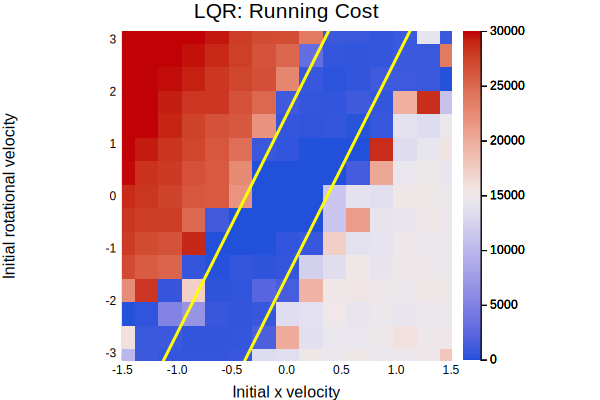

In [142]:
cost_heatmap_annotated("LQR")

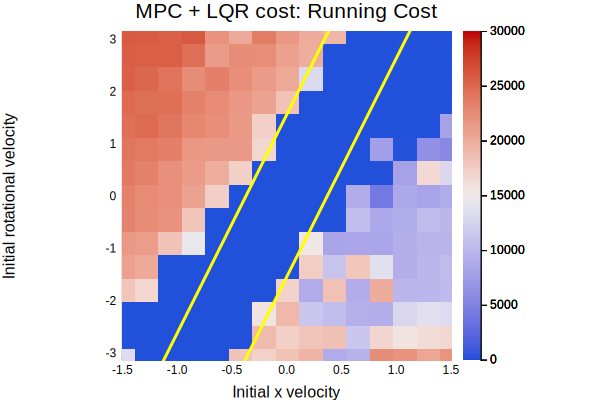

In [143]:
cost_heatmap_annotated("MPC + LQR cost")

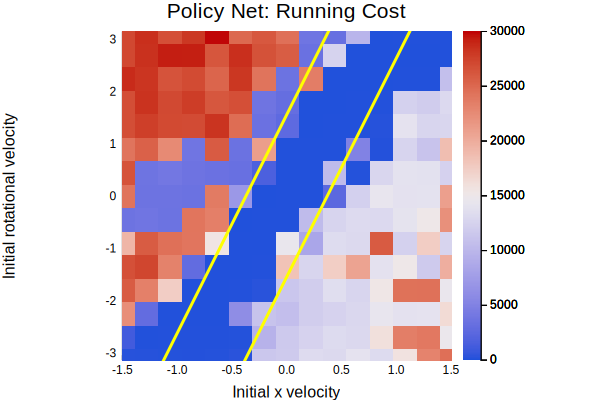

In [144]:
cost_heatmap_annotated("Policy Net")

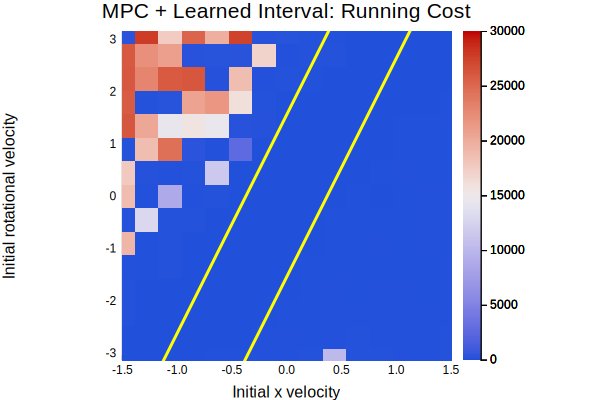

In [145]:
cost_heatmap_annotated("MPC + Learned Interval")

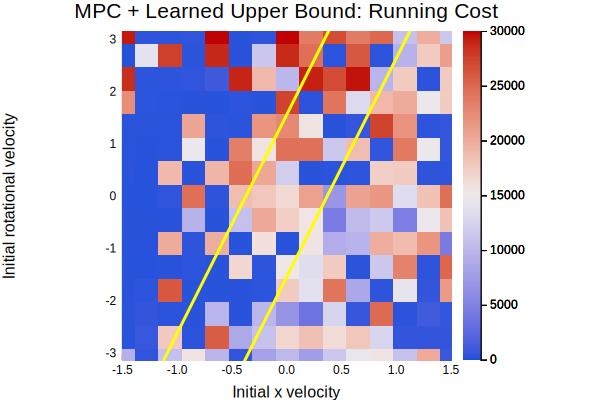

In [146]:
cost_heatmap_annotated("MPC + Learned Upper Bound")

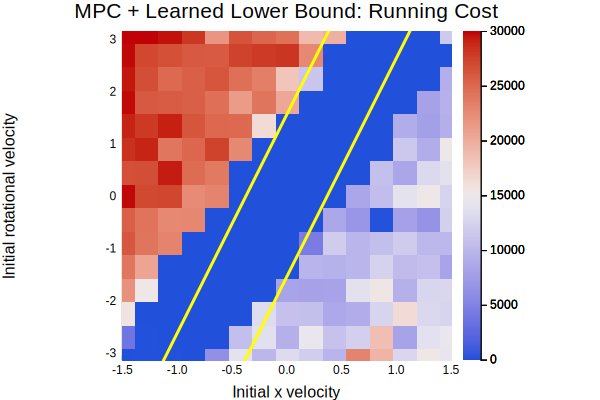

In [147]:
cost_heatmap_annotated("MPC + Learned Lower Bound")